## National Institute for Space Research
   <img src="img/icone_cap394.svg" align="right" alt="Drawing" style="width: 200px;"/>
   
#### Project for course  Introduction to Data Science - CAP 394
#### Student: 
* Helvecio Bezerra Leal Neto

#### Instructors: 
* Dr. Gilberto Queiroz 
* Dr. Rafael Santos

## Schedule
     - [x] Data reading
     - [x] Data visualization
     - [ ] Cluster detection algorithm
     - [ ] Preprocessing
     - [ ] Final analysis and project elaboration

### Index

  [About](#about) <br></br>
  [The Data](#the_data)<br></br>
  [Reading Data](#reading_data)<br></br>

<a id='about'></a>
## About

This work is part of the suite of applications for the Introduction to Data Science (CAP-394) course offered by the National Institute for Space Research.

The purpose of this paper is to perform an exploratory analysis on Radar data by surveying the raw data, processing them and understanding the dynamics of cloud movement in the study region. At the end of the exploratory process it will be possible to estimate the behavior of the clouds in relation to their movement, making an algorithm capable of estimating the movement from two consecutive images.

<a id='the_data'></a>
## The Data

The data analyzed in this example consists of NC (NetCDF4) files. Each file corresponds to Rain Rate measurements collected by the Amazon Protection System (SIPAM) radar during the GoAmazon experiment periods, starting from January 2014 to December 2015, such files contain data on 12-minute time intervals.

https://www.arm.gov/research/campaigns/amf2014goamazon

<a id='reading_data'></a>
## Reading Data

#### 1.1 - Libraries used

In [1]:
import datetime
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.basemap import Basemap
from matplotlib import animation

#%matplotlib
%matplotlib inline

#### 1.2 openning example file

In [2]:
## NC Files from SIPAM RADAR
xds = xr.open_dataset('data/radar/20140201/sbmn_rain_rates_20140201_000009.nc')
xds

<xarray.Dataset>
Dimensions:     (x0: 241, y0: 241)
Dimensions without coordinates: x0, y0
Data variables:
    start_time  datetime64[ns] ...
    stop_time   datetime64[ns] ...
    lat0        (y0, x0) float32 ...
    lon0        (y0, x0) float32 ...
    rain_rate   (y0, x0) float32 ...
Attributes:
    description:  SIPAM Manaus S-Band Gridded Rain Rates
    source:       SIPAM Manaus S-Band Radar
    institution:  SIPAM/Texas A&M University
    comment:      v2.0a; Created at Texas A&M University (cschu@tamu.edu)
    references:   http://atmo.tamu.edu/goamazon-sband-radar
    created:      Wed Sep  6 19:22:46 2017\n

#### 1.3 Variables present in the dataset

In [3]:
xds.data_vars

Data variables:
    start_time  datetime64[ns] ...
    stop_time   datetime64[ns] ...
    lat0        (y0, x0) float32 ...
    lon0        (y0, x0) float32 ...
    rain_rate   (y0, x0) float32 ...

#### 1.4 Attributes from dataset

In [4]:
xds.attrs

OrderedDict([('description', 'SIPAM Manaus S-Band Gridded Rain Rates'),
             ('source', 'SIPAM Manaus S-Band Radar'),
             ('institution', 'SIPAM/Texas A&M University'),
             ('comment',
              'v2.0a; Created at Texas A&M University (cschu@tamu.edu)'),
             ('references', 'http://atmo.tamu.edu/goamazon-sband-radar'),
             ('created', 'Wed Sep  6 19:22:46 2017\n')])

In [5]:
rr = xds.rain_rate                  ### Matrix with preciptation values
runit = xds.rain_rate.units         ### Unit of rain_rate mm/h
rkm = xds.rain_rate.height_km       ### Unit of matrix dimensions km
start_time = xds.start_time.data    ### Initial Time
stop_time = xds.stop_time.data      ### Final Time
lon = xds.lon0.data                 ### Coordinate Longitude Matrix
lat = xds.lat0.data                 ### Corrdinate Latitude Matrix
x0 = xds.x0                         ### Matrix of points
y0 = xds.y0

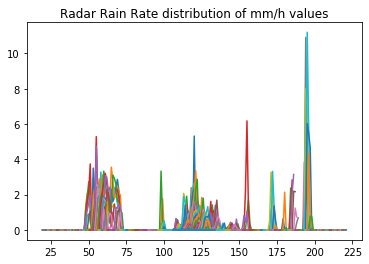

In [6]:
plt.plot(rr)
plt.title('Radar Rain Rate distribution of mm/h values')
plt.show()

#### 1.5 Setuping simple example

In [7]:
## Set data dir
datadir = 'data/radar/'
ddate = 20140201
interval = 50


In [8]:
# Original grid dimensions
nx = 241
ny = 241

# pixel size (in meters)
dx = 1000.
dy = 1000.

downsizeby = 1

# Compute grid dimensions and grid coordinates after resampling
dx2, dy2 = dx*downsizeby, dy*downsizeby
nx2, ny2 = int(nx/downsizeby), int(ny/downsizeby)

X2, Y2 = np.meshgrid( np.arange(0,nx2*dx2, dx2), np.arange(0,ny2*dy2, dy2) )

# Define container
frames = np.zeros( (interval, nx2, ny2 ) )


### Reading files to numpy array (time,x,y)
for i in range(interval):
    d = str(datadir)+str(ddate)+'/'
    file = (sorted(os.listdir(datadir+str(ddate)))[i])
    xds = xr.open_dataset(d+file)
    rr = xds.rain_rate
    frames[i] =  rr

In [9]:
def centroid(data):
    
    sizeM = len(data[0])
    
    for k in range(len(data)):
        maxx = np.nanmax(data[k])
        for i in range(sizeM):
            for j in range(sizeM):
                if data[k][i][j] == maxx:
                    print ('Tempo: ',k, 'max: ', maxx, 'X: ',x0[i].data, 'Y: ',y0[j].data)

In [10]:
def limiar(data):

    lMax = len(data[0])
    llim = np.zeros((data.shape[0],data.shape[1],data.shape[2]))
    #llim[llim == 0] = np.float32('nan')
    
    for k in range(len(data)):
        for i in range(lMax):
            for j in range(lMax):
                if data[k][i][j] > 5:
                    llim[k][i][j] = data[k][i][j]
                    
    for k in range(len(data)):
        for i in range(lMax):
            for j in range(lMax):
                if np.isnan(data[0][i][j]):
                    llim[k][i][j] = data[0][i][j]
    return llim

In [11]:
def getRange(data):
    
    rrange = np.zeros((241,241))
    
    for i in range(241):
        for j in range(241):
            if np.isnan(data[0][i][j]):
                rrange[i][j] = data[0][i][j]
    return rrange

In [12]:
ll = limiar(frames)

#### 1.6 Plot simple example without colormap legends for Time Zero

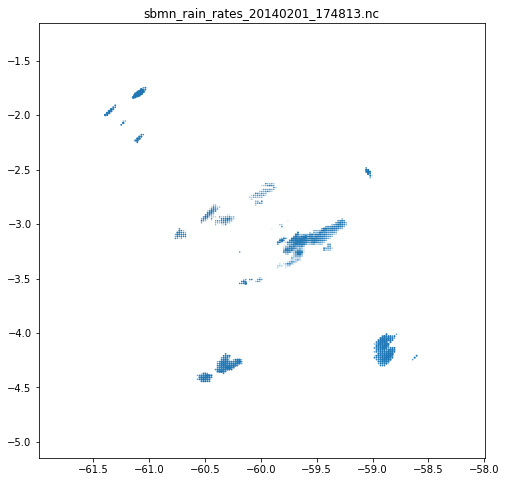

In [13]:
## Plot simple figure from dataset

figtime = 0

plt.figure(figsize=(8,8))
plt.title(os.listdir(datadir+str(ddate))[figtime])
plt.scatter(lon,lat,frames[figtime])
#plt.pcolormesh(lon,lat,frames[figtime])

#### 1.7 Plotexample with colormap and legends for Time Zero

/ssd/CAP-394/lib/radar_plot.py:58: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
/ssd/CAP-394/lib/radar_plot.py:81: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m.drawstates()
/ssd/CAP-394/lib/radar_plot.py:82: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m.drawcountries()
/ssd/CAP-394/lib/radar_plot.py:85: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m.drawrivers(color = '#0043CB', linewidth=1)


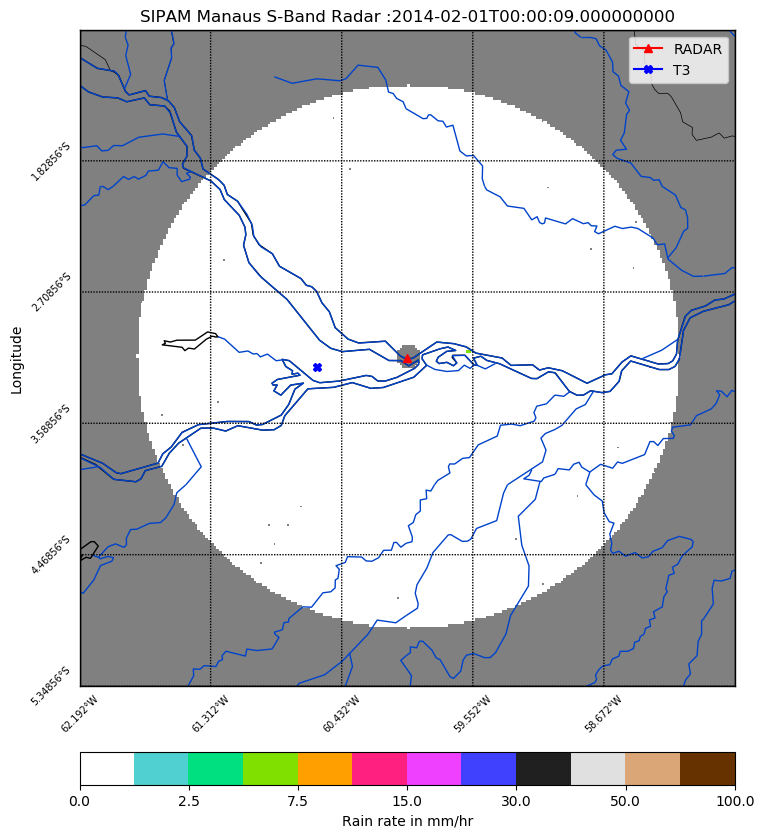

In [14]:
from lib.radar_plot import radar_plot
img = radar_plot(rr=ll[1],runit=runit,lat=lat,lon=lon,start_time=start_time,stop_time=stop_time)

In [ ]:
### Without Radar range
frame = np.nan_to_num(frames[10])

#### 1.7 Function for create Animation (Giff File in root dir)

/ssd/miniconda3/envs/cap394/lib/python3.6/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/ssd/miniconda3/envs/cap394/lib/python3.6/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/ssd/miniconda3/envs/cap394/lib/python3.6/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/ssd/miniconda3/envs/cap394/lib/python3.6/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


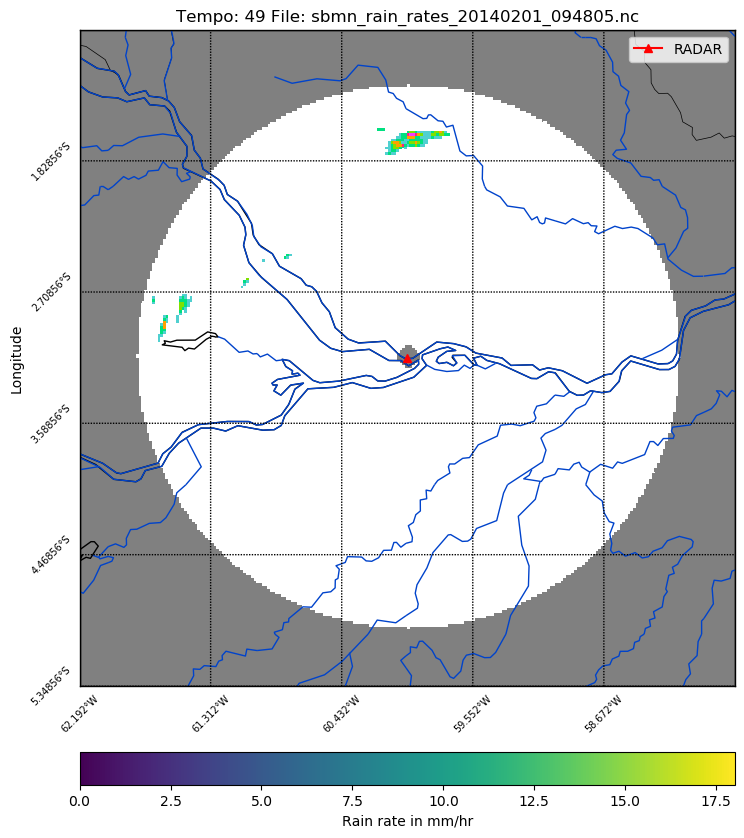

In [16]:
my_coords = [-3.148556, -59.992000]     ## RADAR T1 SIPAM COORDS
zoom_scale = 2.2                        ## ZOOM SCALE

fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(10,10),dpi=100)

# draw filled contours.
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
             50, 70, 100]

cmap_data = [(1.0, 1.0, 1.0),
                 (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
                 (0.0, 1.0, 1.0),
                 (0.0, 0.8784313797950745, 0.501960813999176),
                 (0.0, 0.7529411911964417, 0.0),
                 (0.501960813999176, 0.8784313797950745, 0.0),
                 (1.0, 1.0, 0.0),
                 (1.0, 0.6274510025978088, 0.0),
                 (1.0, 0.0, 0.0),
                 (1.0, 0.125490203499794, 0.501960813999176),
                 (0.9411764740943909, 0.250980406999588, 1.0),
                 (0.501960813999176, 0.125490203499794, 1.0),
                 (0.250980406999588, 0.250980406999588, 1.0),
                 (0.1254900203499794, 0.125490203499794, 0.501960813999176),
                 (0.125490203499794, 0.125490203499794, 0.125490203499794),
                 (0.501960813999176, 0.501960813999176, 0.501960813999176),
                 (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
                 (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
                 (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
                 (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
                 (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
norm = mcolors.BoundaryNorm(clevs, cmap.N)
ax = axes

label = 'Rain rate in ' + runit
title = os.listdir(datadir+str(ddate))[0]


## BASEMAP
bbox = [my_coords[0]-zoom_scale,my_coords[0]+zoom_scale,\
        my_coords[1]-zoom_scale,my_coords[1]+zoom_scale]

m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')

## SIPAM RADAR
xm, ym = m(my_coords[1],my_coords[0])
radar = m.plot(xm,ym, marker='^',color='r', label='RADAR')

# # # # Add Grid Lines
m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0],rotation=45, size=(7))
m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45, size=(7))
m.drawmapboundary(fill_color='gray')

m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawrivers(color = '#0043CB', linewidth=1)

# # # # # Add Title
plt.title(title)
plt.legend()
plt.ylabel('Longitude', labelpad=40)
plt.xlabel('Latitude', labelpad=60)

#CLOUDS
xi, yi = m(lon, lat)
cs = m.pcolormesh(xi,yi,frames[0],cmap = cmap, norm = norm, ax=ax)
cs = m.pcolormesh(xi,yi,rr)

def init():
    return cs,

def animate(i):
    plt.title('Tempo: ' + str(i) + ' File: '+sorted(os.listdir(datadir+str(ddate)))[i])#)
    m.pcolormesh(xi,yi,frames[i],cmap = cmap, norm = norm, ax=ax)
    return cs,

# # # # # Add Colorbar
cbar = m.colorbar(cs, location='bottom', pad="10%")
cbar.set_label(label)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=interval,  blit=True, repeat=True, save_count=interval)
anim.save(os.listdir(datadir+str(ddate))[0]+'.gif', writer='imagemagick', fps=1)

#### RESULTS

#### CONCLUSIONS

#### REFERENCES